## About the dataset:
* All the pictures in the dataset are JPEGs. 
* This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed).

## Approach we'll be following:
* We'll create a new dataset completely contining three parts:
1. Training set: 1000 samples from each dog and cat class
2. Validation set: 500 samples from each class again
3. Test set: 1000 samples from each class

Why not use the whole training data: As its my learning phase and im sure that im not alone in the learning phase, so in real world many of the image datasets would only contain a few thousand images, so its a good practice to learn with small datasets.

## Froming different subsets of our data:

In [2]:
import os, shutil, pathlib

orignal_directory_path = '/kaggle/input/dogs-vs-cats/train'
orignal_directory = pathlib.Path(orignal_directory_path) #existing training data
new_base_directory = pathlib.Path('cats_vs_dogs_subset') #new directory for our subset

In [3]:
def make_subset(subset_name,start_index,end_index):
    for category in ['cat','dog']:
        dir = new_base_directory / subset_name / category
        os.makedirs(dir)
        file_names = [f'{category}.{i}.jpg'
                     for i in range(start_index,end_index)]
        for fname in file_names:
            shutil.copyfile(src= orignal_directory / fname,
                           dst= dir / fname)

make_subset('train', start_index=0, end_index=1000)
make_subset('validation', start_index=1000, end_index=1500)
make_subset('test', start_index=1500, end_index=2500)

We now have 3 subsets of the data to train, validate and run tests on. Each split/subset is a balanced one since they all contain equal number of samples from each class(i.e. Dog and Cat), it bascically becomes a binary_classification problem which makes accuracy as a good metrics to evaluate on. 

## Building the model:
This convnet model will be a stack of alternately placed Conv2D(with activation='relu') and MaxPooling layers.
We'll start from inputs of size 180 pixels x 180 pixels, and will end up with feature maps of size 7x7 just before the Flatten layer.

Since its a binary classification problem the last layer will be a dense layer with 1 unit and sigmoid activation.

We will start the model with a Rescaling layer, which will rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range. Why?? Its simple just as a grayscale images pixal is a number between 0-255 similarly in RGB images the pixal is [0-255,0-255,0-255] so 1/255 * pixal --> [0-1,0-1,0-1]. 

What are the benifits of this rescaling???
### Benefits of rescaling:
* Gradient descent works much better when inputs are normalized. The model reaches good performance in fewer epochs.
* Neural networks use many multiplications and activations. Smaller numbers = less risk of exploding values.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180,180,3), name='input_layer') #RGB images of size 180x180
x = layers.Rescaling(1./255, name='rescaling_layer') (inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', name='convolution_layer_1') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_1') (x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='convolution_layer_2') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_2') (x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', name='convolution_layer_3') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_3') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_4') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_4') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_5') (x)
x = layers.Flatten() (x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer') (x)

model = keras.Model(inputs=inputs, outputs=outputs, name='classifier_convnet_1')

2026-02-07 13:36:28.121578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770471388.541549      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770471388.683775      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770471389.608775      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770471389.608814      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770471389.608817      55 computation_placer.cc:177] computation placer alr

In [5]:
model.summary()

Model: "classifier_convnet_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_layer (Rescaling)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_1 (Conv2D)    │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_1 (MaxPooling2D)     │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_2 (Conv2D)    │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_2 (MaxPooling2D)     │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_3 (Conv2D)    │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_3 (MaxPooling2D)     │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_4 (Conv2D)    │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_4 (MaxPooling2D)     │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_5 (Conv2D)    │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model: 

In [6]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

## Data Preprocesssing:
Right now the data is in our directory in form of JPEGs so we'll need to:
*  Decode the JPEG content to RGB grids of pixals.
*  Convert these into floating-point tensors.
*  Resize them to a shared size of 180x180 which is input shape of our model.
*  Pack them into batches(here batch_size will be 32)

Keras features the utility function 
*image_dataset_from_directory()*
, which lets us quickly set up a data pipeline that can automatically turn
image files on disk into batches of preprocessed tensors.

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_directory / 'train',
    image_size=(180,180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_directory / 'validation',
    image_size=(180,180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_directory / 'test',
    image_size=(180,180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


The output of teh above piece of code are Dataset objects, it yields batches of 180  180
RGB images (shape (32, 180, 180, 3)) and integer labels (shape (32,)). There are
32 samples in each batch (the batch size).

In [8]:
for data_batch, labels_batch in train_dataset:     
    print("data batch shape:", data_batch.shape)     
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Fitting the data to the model:
We'll also pass *validation_data* argument in the **fit()** method to keep track of validation metrics.

Also using **ModelCheckpoint** callback to save the model after each epoch. Arguments *save_best_only=True* and *monitor="val_loss"* will also be passed they tell the callback to
only save a new file (overwriting any previous one) when the current value of the
val_loss metric is lower than at any previous time during training. 
As a result, we won’t have to retrain a new model for a lower number of epochs if we start
overfitting: we can just reload our saved file.

In [9]:
#Defining teh callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "best_convnet_classifer_so_far.keras",
        save_best_only = True,
        monitor = 'val_loss')
]

#fitting data to the model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/30


I0000 00:00:1770471412.950722     125 service.cc:152] XLA service 0x7fa9a4025bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770471412.950766     125 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770471412.950776     125 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770471413.411715     125 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-07 13:36:56.603463: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 13:36:56.751564: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5514 - loss: 0.8707

I0000 00:00:1770471419.097325     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5017 - loss: 0.7344

2026-02-07 13:37:02.590140: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 13:37:02.734919: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5020 - loss: 0.7334 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5342 - loss: 0.6923 - val_accuracy: 0.5100 - val_loss: 0.6902
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5672 - loss: 0.6848 - val_accuracy: 0.6150 - val_loss: 0.6727
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6259 - loss: 0.6569 - val_accuracy: 0.5790 - val_loss: 0.6726
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6545 - loss: 0.6299 - val_accuracy: 0.6480 - val_loss: 0.6289
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6908 - loss: 0.5996 - val_accuracy: 0.6260 - val_loss: 0.6581
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7072 - loss: 0.5788 - val_accuracy: 0.6350 - val_loss: 0.6302
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7193 - loss: 0.5406 - val_accuracy: 0.6670 - val_loss: 

## Plotting the loss and accuracy:

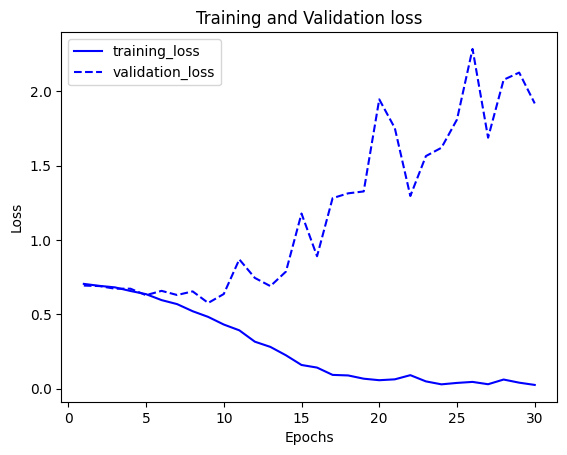

In [11]:
import matplotlib.pyplot as plt

# training_loss and val_loss on each epoch 
epochs = 30
training_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1,epochs+1), training_loss, 'b-', label='training_loss')
plt.plot(range(1,epochs+1), val_loss, 'b--', label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

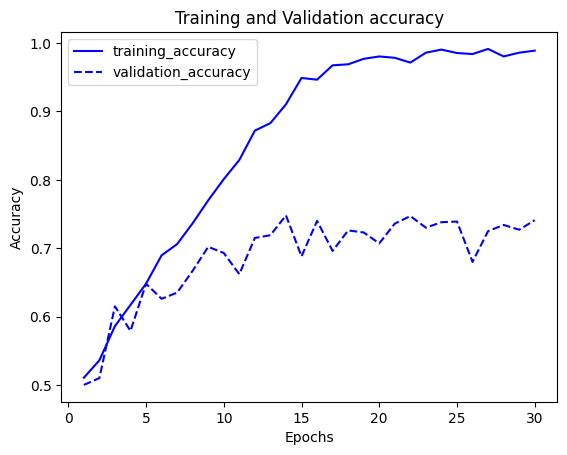

In [12]:
#plotting training_accuracy and validation_accuracy

training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1,epochs+1), training_acc, 'b-', label='training_accuracy')
plt.plot(range(1,epochs+1), val_acc, 'b--', label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

The above graphs showcase clear overfitting. Where training accuracy reaches 100% eventually and validation_accuracy peaks at approx 75%. Similarly validation loss reaches its lowest at epoch=10 thereafter it keeps on increasing while the training loss keeps decreasing.

## Evaluating the saved best model on test set:

In [15]:
test_model = keras.models.load_model('best_convnet_classifer_so_far.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7029 - loss: 0.5846
Test accuracy: 0.708


Test accuracy achived was 70.8%